# BigQuery Exploration

In [1]:
from google.colab import auth
from google.cloud import bigquery
%load_ext rpy2.ipython

project='isb-cgc-outreach'
auth.authenticate_user()
client = bigquery.Client(project=project)
print('Authenticated')

Authenticated


In [ ]:
%%R
install.packages('bigrquery')
install.packages('repr')

In [5]:
%%R
project <- '<your_google_project>'
library(bigrquery)
library(repr)

## SQL queries
SQL queries are fundamentally very similar to subsetting R data frames, where the syntax of subsetting an R data frame is as follows:

> *dataframe*[ ,*column* ][ *conditional* ]

The equivalent operation in SQL would look like this:

> SELECT *column* FROM *table* WHERE *conditional*



## Clinical and cohort queries
In this section we want to showcase how researchers can find clinical information of GDC cases. How can you quickly construct a cohort. As an example, how old are the patients for each case in a given project?

Tables used: *isb-cgc-bq.TCGA.clinical_gdc_current*

In [6]:
%%R
# Our first query is to retrieve the columns present
column_sql <- "SELECT 
    column_name 
FROM isb-cgc-bq.TCGA_versioned.INFORMATION_SCHEMA.COLUMNS 
WHERE table_name = 'clinical_gdc_r26'"

column_query <- bq_project_query(project, query=column_sql)
case_df <- as.vector(unlist(bq_table_download(column_query)))
paste(case_df, collapse=', ')

R[write to console]: Complete

R[write to console]: Billed: 10.49 MB

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



[1] "submitter_id, case_id, diag__treat__count, primary_site, disease_type, proj__name, proj__project_id, demo__demographic_id, demo__gender, demo__race, demo__ethnicity, demo__vital_status, demo__days_to_birth, demo__year_of_birth, demo__age_at_index, demo__year_of_death, demo__days_to_death, demo__state, demo__created_datetime, demo__updated_datetime, diag__diagnosis_id, diag__ajcc_clinical_n, diag__masaoka_stage, diag__ajcc_clinical_m, diag__primary_diagnosis, diag__primary_gleason_grade, diag__year_of_diagnosis, diag__figo_stage, diag__progression_or_recurrence, diag__ajcc_pathologic_m, diag__site_of_resection_or_biopsy, diag__ajcc_staging_system_edition, diag__icd_10_code, diag__age_at_diagnosis, diag__ajcc_clinical_t, diag__days_to_last_follow_up, diag__ajcc_pathologic_stage, diag__tumor_grade, diag__last_known_disease_status, diag__ann_arbor_extranodal_involvement, diag__ajcc_clinical_stage, diag__secondary_gleason_grade, diag__synchronous_malignancy, diag__morphology, diag__ajc

In [7]:
%%R
# our second query retrieves the ages of all TCGA-BRCA cases
case_sql <- "SELECT
  submitter_id,
  demo__age_at_index,
  demo__vital_status,
FROM `isb-cgc-bq.TCGA_versioned.clinical_gdc_r27`
WHERE proj__project_id = 'TCGA-BRCA'
"
case_query <- bq_project_query(project, query=case_sql)
case_df <- as.data.frame(bq_table_download(case_query))
head(case_df)

# Try substituting alternate or adding columns such as:
#   demo__vital_status
#   demo__race
# Find all the unique values that are in a column by querying only for:
#   distinct demo__race
# Try subseting the results by use of the where clause:
#   proj__project_id = 'TCGA-BRCA'
#   demo__age_at_index <= 70 AND demo__age_at_index >= 40

R[write to console]: Complete

R[write to console]: Billed: 10.49 MB

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



  submitter_id demo__age_at_index demo__vital_status
1 TCGA-A8-A07E                 81              Alive
2 TCGA-A8-A099                 76              Alive
3 TCGA-A8-A09A                 40              Alive
4 TCGA-A8-A09C                 69              Alive
5 TCGA-B6-A0I8                 46               Dead
6 TCGA-B6-A0RE                 61              Alive


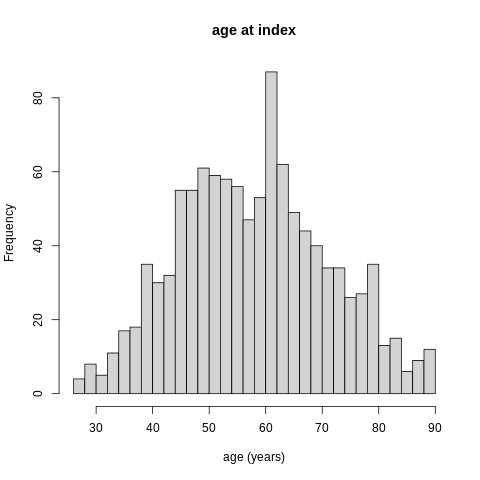

In [8]:
%%R
# since we have the data in R we can directly generate visuals
options(repr.plot.width=7, repr.plot.height=5.5)
case_num <- length(unique(case_df[,2]))
hist(case_df[,2], breaks=case_num/2, main='age at index', xlab='age (years)')

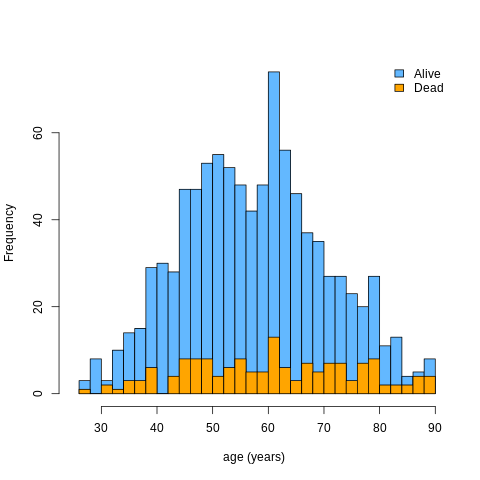

In [9]:
%%R
# including separating by vital status
hist(case_df[case_df[,3] == 'Alive',2], 
     breaks=case_num/2, xlim=c(25,90), 
     col='steelblue1', main='', xlab='age (years)')
hist(case_df[case_df[,3] == 'Dead',2], 
     breaks=case_num/2, add=1, col='orange')
legend('topright', bty='n', legend=c('Alive', 'Dead'), fill=c('steelblue1', 'orange'))

## Gene expression
Another common question researchers encounter is, given a gene of interest what is the expression pattern in cancers? Using the GDC expression tables it's possible to retrieve huge amounts of information and do high level comparisons quickly.

Tables used: *isb-cgc-bq.TCGA_versioned.RNAseq_hg38_gdc_r28*

In [10]:
%%R
# a query to retrieve FPKM_UQ values for one specific gene (CCNB1)
expr_sql <- "SELECT
  case_barcode,
  aliquot_barcode,
  sample_type_name,
  HTSeq__FPKM_UQ
FROM `isb-cgc-bq.TCGA_versioned.RNAseq_hg38_gdc_r28`
WHERE project_short_name = 'TCGA-BRCA'
  AND gene_name = 'BRCA1' #'CCNB1'"

expr_query <- bq_project_query(project, query=expr_sql)
expr_df <- bq_table_download(expr_query)
head(expr_df)

# try changing the project_short_name to 'TCGA-LUAD'
# or substitute HTSeq__FPKM_UQ to retrieve other measures
#    HTSeq__counts
#    HTSeq__FPKM
# change the gene name
#    BRCA1
#    BRCA2
#    FOXA1

R[write to console]: Complete

R[write to console]: Billed: 59.85 GB

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



# A tibble: 6 × 4
  case_barcode aliquot_barcode              sample_type_name    HTSeq__FPKM_UQ
  <chr>        <chr>                        <chr>                        <dbl>
1 TCGA-BH-A0DX TCGA-BH-A0DX-01A-11R-A115-07 Primary Tumor               25734.
2 TCGA-E2-A10C TCGA-E2-A10C-01A-21R-A10J-07 Primary Tumor               49893.
3 TCGA-BH-A0DO TCGA-BH-A0DO-11A-22R-A12D-07 Solid Tissue Normal         26668.
4 TCGA-AR-A24X TCGA-AR-A24X-01A-11R-A169-07 Primary Tumor               65655.
5 TCGA-E2-A572 TCGA-E2-A572-01A-13R-A31O-07 Primary Tumor               18924.
6 TCGA-BH-A0BQ TCGA-BH-A0BQ-11A-33R-A115-07 Solid Tissue Normal         35066.


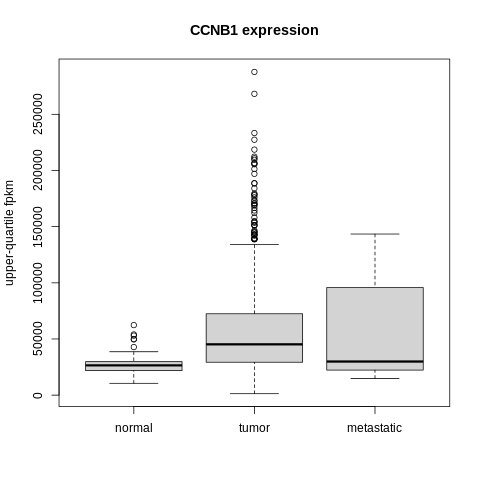

In [11]:
%%R
options(repr.plot.width=5, repr.plot.height=6)
tumor <- unlist(expr_df[expr_df[,3] == 'Primary Tumor',4])
normal <- unlist(expr_df[expr_df[,3] == 'Solid Tissue Normal',4])
metastatic <- unlist(expr_df[expr_df[,3] == 'Metastatic',4])

boxplot(list(normal, tumor, metastatic), names=c('normal', 'tumor', 'metastatic'), main='CCNB1 expression', ylab='upper-quartile fpkm')

As the size of the data of interest increases, calculating statistics on a local machine may become prohibitive. One of the benefits of BigQuery is that it scales compute power to the demands of the query. We can functions built into BQ to generate summary statistics.

In [12]:
%%R
# This query will calculate averages, standard deviations, maximums, and minimums
summ_sql <- "SELECT
  project_short_name,
  sample_type_name,
  count( distinct aliquot_barcode ) count_aliq,
  avg(HTSeq__FPKM_UQ) avg_fpkm,
  stddev(HTSeq__FPKM_UQ) sdv_fpkm,
  max(HTSeq__FPKM_UQ) max_fpkm,
  min(HTSeq__FPKM_UQ) min_fpkm
FROM `isb-cgc-bq.TCGA_versioned.RNAseq_hg38_gdc_r28`
WHERE gene_name = 'CCNB1'
GROUP BY project_short_name, sample_type_name
"

summ_query <- bq_project_query(project, query=summ_sql)
summ_df <- bq_table_download(summ_query)
head(summ_df)

# Other functions such as count and distinct can add useful information
#    count( distinct aliquot_barcode )
# Retrieve results for all genes or for all projects by
# removing gene_name from the WHERE clause 
# and adding it to SELECT and GROUP BY

R[write to console]: Complete

R[write to console]: Billed: 50.46 GB

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



# A tibble: 6 × 7
  project_short_name sample_type_name    count_aliq avg_fpkm sdv_fpkm max_fpkm
  <chr>              <chr>                    <int>    <dbl>    <dbl>    <dbl>
1 TCGA-BRCA          Primary Tumor             1102  487856.  330627. 2367487.
2 TCGA-SARC          Primary Tumor              259  545409.  416261. 2207545.
3 TCGA-THCA          Solid Tissue Normal         58  134963.   66662.  546708.
4 TCGA-BLCA          Primary Tumor              414  733647.  482419. 3520079.
5 TCGA-HNSC          Primary Tumor              500  875407.  482961. 3501559.
6 TCGA-PCPG          Primary Tumor              178   75713.   35387.  296912.
# … with 1 more variable: min_fpkm <dbl>


In [13]:
%%R
# summ_sql <- "SELECT
#  sample_type_name,
#  project_short_name,
#  avg(HTSeq__FPKM_UQ) avg_fpkm,
#  stddev(HTSeq__FPKM_UQ) sdv_fpkm,
#  max(HTSeq__FPKM_UQ) max_fpkm,
#  min(HTSeq__FPKM_UQ) min_fpkm
#FROM `isb-cgc-bq.TCGA_versioned.RNAseq_hg38_gdc_r28`
#WHERE gene_name = 'CCNB1'
#GROUP BY project_short_name,sample_type_name"

NULL


## Genome annotation
If we need annotation information about a gene it's possible to quickly retrieve Gencode annotation from ISB-CGC hosted BigQuery tables.

Table: *isb-cgc-bq.GENCODE_versioned.annotation_gtf_hg38_v22*

In [14]:
%%R
annot_sql <- "SELECT * 
FROM `isb-cgc-bq.GENCODE_versioned.annotation_gtf_hg38_v22`
WHERE gene_name = 'CCNB1' 
  AND transcript_name = 'CCNB1-001'"

annot_query <- bq_project_query(project, query=annot_sql)
annot_df <- bq_table_download(annot_query)
annot_df

R[write to console]: Complete

R[write to console]: Billed: 947.91 MB

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



# A tibble: 23 × 32
   seq_name source feature        start      end frame strand gene_name gene_id 
   <chr>    <chr>  <chr>          <int>    <int> <chr> <chr>  <chr>     <chr>   
 1 chr5     HAVANA CDS         69171270 69171452 .     +      CCNB1     ENSG000…
 2 chr5     HAVANA CDS         69167908 69168078 .     +      CCNB1     ENSG000…
 3 chr5     HAVANA CDS         69167263 69167283 .     +      CCNB1     ENSG000…
 4 chr5     HAVANA start_codon 69167263 69167265 .     +      CCNB1     ENSG000…
 5 chr5     HAVANA exon        69174877 69175113 .     +      CCNB1     ENSG000…
 6 chr5     HAVANA UTR         69167010 69167262 .     +      CCNB1     ENSG000…
 7 chr5     HAVANA exon        69168173 69168343 .     +      CCNB1     ENSG000…
 8 chr5     HAVANA stop_codon  69177629 69177631 .     +      CCNB1     ENSG000…
 9 chr5     HAVANA exon        69177524 69178245 .     +      CCNB1     ENSG000…
10 chr5     HAVANA CDS         69177239 69177349 .     +      CCNB1     ENSG000…
# … with

## Mutation data
You may encounter a mutation and wonder if it's represented in other cancer data. Given the gene annotation data from above we can query the somatic mutation table for mutations within a gene.

Table: *isb-cgc-bq.TCGA_versioned.somatic_mutation_hg38_gdc_r10*

In [15]:
%%R
# this query retrieves all mutations falling between the start codon and the stop codon of our gene.
mut_sql <- "SELECT case_barcode, 
    Chromosome, 
    Start_Position, 
    End_Position, 
    Reference_Allele, 
    Tumor_Seq_Allele1, 
    Tumor_Seq_Allele2
FROM `isb-cgc-bq.TCGA_versioned.somatic_mutation_hg38_gdc_r10`
WHERE Chromosome = 'chr5'
    AND Start_Position >= 69167263
    AND End_Position <= 69177631"

mut_query <- bq_project_query(project, query=mut_sql)
mut_df <- bq_table_download(mut_query)
head(mut_df)
nrow(mut_df)

R[write to console]: Complete

R[write to console]: Billed: 164.63 MB

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



[1] 68


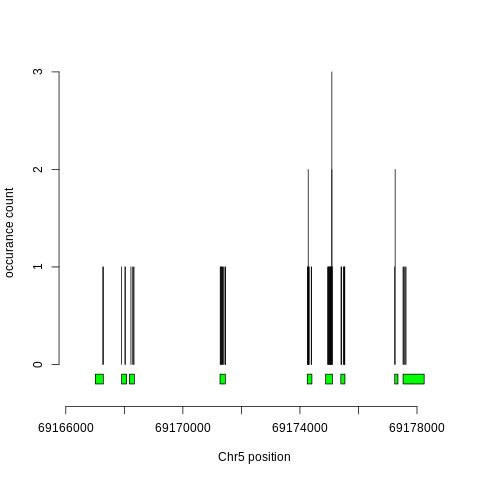

In [17]:
%%R
# we can plot the positions and number of mutations on the chromosome
options(repr.plot.width=15, repr.plot.height=4)
mut_count <- table(mut_df[,3])
max_count <- max(mut_count)
plot(NA, xlim=c(min(mut_df[,3])-1000, max(mut_df[,3])+1000), ylim=c(-0.3,max_count), 
     yaxt='n', bty='n', main='', xlab='Chr5 position', ylab='occurance count')
jnk <- apply(annot_df[annot_df$feature == 'exon',], 1, function(row){
    rect(row[4], -0.2, row[5], -0.1, col='green')
})
axis(2, at=seq(0,3,1))
jnk <- sapply(1:length(mut_count), function(ix){
    x <- as.numeric(names(mut_count)[ix])
    segments(x, 0, x, mut_count[ix])
    })

In [18]:
%%R
sql <- "SELECT
    case_barcode, 
    Chromosome, 
    Start_Position, 
    End_Position, 
    Reference_Allele, 
    Tumor_Seq_Allele1, 
    Tumor_Seq_Allele2
FROM `isb-cgc-bq.TCGA_versioned.somatic_mutation_hg38_gdc_r10`
WHERE 
    Chromosome = 'chr5'
    AND ( (Start_Position < 69067135 and Start_Position > 69167135)
        or (End_Position > 69177358 and End_Position < 69277358) )"

query <- bq_project_query(project, query=sql)
df <- bq_table_download(query)
head(df)

R[write to console]: Complete

R[write to console]: Billed: 164.63 MB

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



# A tibble: 6 × 7
  case_barcode Chromosome Start_Position End_Position Reference_Allele
  <chr>        <chr>               <int>        <int> <chr>           
1 TCGA-EY-A1GI chr5             69277338     69277338 A               
2 TCGA-FW-A3R5 chr5             69209874     69209874 C               
3 TCGA-DU-6392 chr5             69217801     69217801 G               
4 TCGA-LD-A74U chr5             69189588     69189588 C               
5 TCGA-BS-A0UF chr5             69255625     69255625 G               
6 TCGA-64-5779 chr5             69226349     69226349 A               
# … with 2 more variables: Tumor_Seq_Allele1 <chr>, Tumor_Seq_Allele2 <chr>


## Table joins
Many use cases for researchers require combined data from multiple of the tables we worked with in the previous examples. How do we join these data using BigQuery?

Tables:
*   *isb-cgc-bq.TCGA_versioned.clinical_gdc_r27*
*   *isb-cgc-bq.TCGA_versioned.somatic_mutation_hg38_gdc_r10*

In [19]:
%%R
sql <- "SELECT
    mut.case_barcode,
    mut.Chromosome, 
    mut.Start_Position, 
    mut.End_Position, 
    mut.Reference_Allele, 
    mut.Tumor_Seq_Allele1, 
    mut.Tumor_Seq_Allele2, 
    clin.demo__vital_status 
FROM `isb-cgc-bq.TCGA_versioned.clinical_gdc_r27` clin
JOIN `isb-cgc-bq.TCGA_versioned.somatic_mutation_hg38_gdc_r10` mut 
    ON clin.submitter_id = mut.case_barcode
WHERE mut.project_short_name = 'TCGA-BRCA'"

query <- bq_project_query(project, query=sql)
df <- bq_table_download(query)
head(df)

R[write to console]: Complete

R[write to console]: Billed: 204.47 MB

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



# A tibble: 6 × 8
  case_barcode Chromosome Start_Position End_Position Reference_Allele
  <chr>        <chr>               <int>        <int> <chr>           
1 TCGA-AN-A0G0 chr2             96240496     96240498 CTC             
2 TCGA-C8-A1HJ chr16             2386226      2386240 CATCGGCATCGCCCT 
3 TCGA-D8-A1JN chr11             1097353      1097359 ATCGACA         
4 TCGA-E2-A573 chr10           118052167    118052173 AGTAAGA         
5 TCGA-HN-A2NL chr7            108884555    108884559 CATTG           
6 TCGA-3C-AALI chr8             18223133     18223135 AAA             
# … with 3 more variables: Tumor_Seq_Allele1 <chr>, Tumor_Seq_Allele2 <chr>,
#   demo__vital_status <chr>


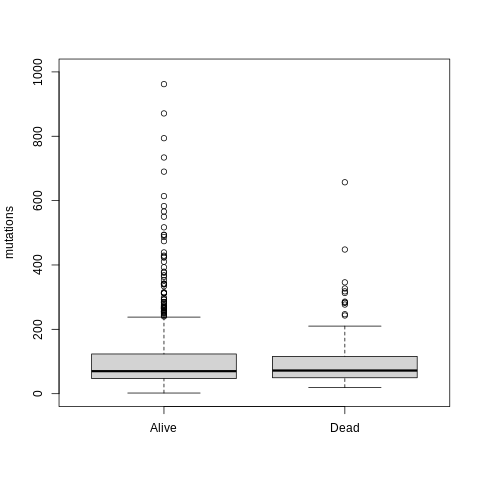

In [20]:
%%R
options(repr.plot.width=5, repr.plot.height=6)
muts_alive <- as.vector(table(df[df['demo__vital_status'] == 'Alive','case_barcode']))
muts_dead <- as.vector(table(df[df['demo__vital_status'] == 'Dead','case_barcode']))
boxplot(muts_alive, muts_dead, ylim=c(0,1000), 
  names=c('Alive', 'Dead'), ylab='mutations')